## Image Compression using Singular Value Decomposition and comparison with SOTA method

**Course:** DSC210: Numerical Linear Algebra for Data Science

**Instructor:** Dr. Tsui-wei Weng

**Group number:** 4

**Group topic:** Topic 11: CV/image processing-related


**Group members:**

*   Dinesh Karthikeyan
*   Nandita Sanjivi
*   Prathish Murugan

### Setup

In [1]:
# To run M1 GPU, SKIP IF NOT NEEDEED

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-13 13:51:25.311743: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-13 13:51:25.311760: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-13 13:51:25.311768: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-13 13:51:25.311815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-13 13:51:25.311850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is NOT available')

GPU is available


## Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os                                                                # Access File path 
import imageio                                                           # To build GIF
import ipywidgets as widgets                                             # For Slider Widgets
from numpy.linalg import svd                                             # To perform SVD
from PIL import Image                                                    # Imaging Library
from skimage.metrics import structural_similarity as ssim
from ipywidgets import interact, interactive, interact_manual
from IPython.display import display
from skimage.io import imread

In [4]:
from ipynb.fs.full.Evaluation_metric import get_mse, ssim_k

## Color Image Processing

In [5]:
# Import the image

own_images = {                                                     # Used as own images
    "Geisel": np.asarray(Image.open('Images/Geisel.webp')),        #Notice different image formats for images
    "Iphone": np.asarray(Image.open('Images/Iphone.jpeg')),
    "Flower": np.asarray(Image.open('Images/Flower.png')),
    "Tamil_food": np.asarray(Image.open('Images/Tamil_food.jpeg')),
    "Cliffs": np.asarray(Image.open('Images/Cliffs.jpeg')),
    "Henry": np.asarray(Image.open('Images/Henry.jpeg')),
}

images = {                                                                      #To compare with SOTA as both same images
    "Portrait": np.asarray(Image.open('Images/SOTA_images/Portrait.png')),        #Notice different image formats for images
    "Tundra": np.asarray(Image.open('Images/SOTA_images/Tundra.png')),
    "Seashore": np.asarray(Image.open('Images/SOTA_images/Seashore.png'))
}

In [6]:
# See the images

def show_images(img_name):
    
    'It will show image in widget'
    
    plt.title("Image Name: "+img_name+"\n")
    plt.imshow(images[img_name])
    plt.show()


interact(show_images, img_name=list(images.keys()))

interactive(children=(Dropdown(description='img_name', options=('Portrait', 'Tundra', 'Seashore'), value='Port…

<function __main__.show_images(img_name)>

In [7]:
# compressed_image = None
# text = None

In [8]:
#Split the image channels into R, G & B 

def split_channel(pic_rgb):
    '''
    Split the image channels into R, G & B 
    '''
    pic_r = pic_rgb[:, :, 0]                      # Red channel
    pic_g = pic_rgb[:, :, 1]                      # Green channel
    pic_b = pic_rgb[:, :, 2]                      # Blue channel

    return pic_r, pic_g, pic_b

In [9]:
def sv_decompose(r,g,b,k,shape):
    '''
    Function to perform SVD and then reconstruct the image for k component
    '''
    
    ur,sr,vr = svd(r, full_matrices=False)        # SVD on Red Channel
    ug,sg,vg = svd(g, full_matrices=False)        # SVD on Green Channel
    ub,sb,vb = svd(b, full_matrices=False)        # SVD on Blue Channel
    
    rr = np.dot(ur[:,:k],np.dot(np.diag(sr[:k]), vr[:k,:]))    # Reconstructing the Image with different k parameter for red
    rg = np.dot(ug[:,:k],np.dot(np.diag(sg[:k]), vg[:k,:]))    # Reconstructing the Image with different k parameter for green
    rb = np.dot(ub[:,:k],np.dot(np.diag(sb[:k]), vb[:k,:]))    # Reconstructing the Image with different k parameter for blue

    rimg = np.zeros(shape)    #Create an array of the image's shape so that we can impose the reconstructed channels
    rimg[:,:,0] = rr
    rimg[:,:,1] = rg
    rimg[:,:,2] = rb

    return rimg               # Return an array

In [10]:
def show_img(compressed_image,img_name):
    '''
    To show the image in a widget mode
    '''
    
    plt.title("Image Name: "+img_name+"\n")
    plt.imshow(compressed_image)
    plt.axis('off')
    plt.show()

    compressed_image = Image.fromarray(compressed_image)
    
    text = widgets.Text(value="image_save",placeholder='Enter image name...',description='Image name')
    display(text)

In [11]:
def compress_image(img_name, k):
    '''
    Function to compress and clip the image
    '''
    global text
    global compressed_image
    img = images[img_name]

    r,g,b = split_channel(img)

    print("compressing...")
    print("Use the Slider for different k values")

    rimg = sv_decompose(r,g,b,k,img.shape)

    rimg = np.clip(np.abs(rimg), 0, 255) 
    #if an interval of [0, 255] is specified, values smaller than 0 become 0, and values larger than 255 become 255
    #the absolute value of each element in the image and then uses "clip" to make the values are within the range [0, 255]. 

    compressed_image = rimg.astype(np.uint8)

    print("MSE between compressed image and original image is: ", get_mse(compressed_image ,img))
    print("SSIM between compressed image and original image is: ", ssim_k(compressed_image, img))
    show_img(compressed_image,img_name)

In [12]:
#Call the widget
interact(compress_image, img_name=list(images.keys()), k = (0,200))

interactive(children=(Dropdown(description='img_name', options=('Portrait', 'Tundra', 'Seashore'), value='Port…

<function __main__.compress_image(img_name, k)>

In [13]:
# Repeat the same functions as above, just to create a GIF

pic_rgb = imread('Images/SOTA_images/Portrait.png')

pic_r = pic_rgb[:, :, 0]
pic_g = pic_rgb[:, :, 1]
pic_b = pic_rgb[:, :, 2]

# SVD decomposition for Red, Green and Blue
U_r, s_r, VT_r = svd(pic_r, full_matrices=False)
U_g, s_g, VT_g = svd(pic_g, full_matrices=False)
U_b, s_b, VT_b = svd(pic_b, full_matrices=False)

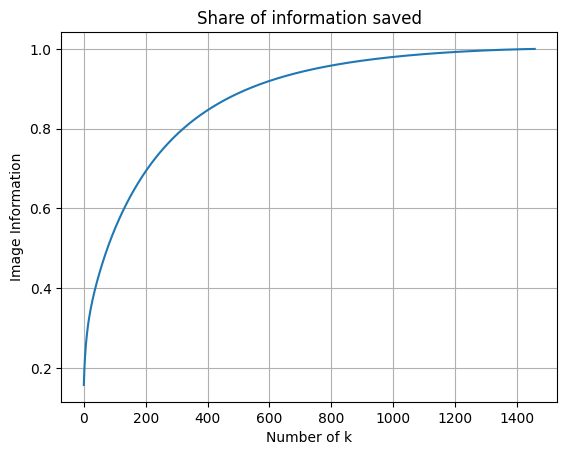

In [14]:
fig, ax = plt.subplots()

ax.plot(np.cumsum(s_r) / np.sum(s_r))
ax.grid()
plt.title('Share of information saved')
ax.set_xlabel('Number of k')
ax.set_ylabel('Image Information')

plt.show()

In [15]:
filenames = []
for r in np.arange(60, 0, -1):
    # r is the number of singular values used

    # Restoring the image
    pic_reduce_r = U_r[:, :r] @ np.diag(s_r[:r]) @ VT_r[:r, :]
    pic_reduce_g = U_g[:, :r] @ np.diag(s_g[:r]) @ VT_g[:r, :]
    pic_reduce_b = U_b[:, :r] @ np.diag(s_b[:r]) @ VT_b[:r, :]

    pic_reduce_rgb = np.stack(
        [pic_reduce_r, pic_reduce_g, pic_reduce_b], axis=2)
    # Crop values to the range [0, 255]
    pic_reduce_rgb[pic_reduce_rgb < 0.] = 0
    pic_reduce_rgb[pic_reduce_rgb > 255.] = 255

    plt.imshow(pic_reduce_rgb.astype('uint8'))
    plt.axis('off')
    plt.savefig(str(r) + '.png')

    name = f'{r}.png'
    filenames.append(name)

    # save frame
    plt.savefig(name)
    plt.close()

In [16]:
# build gif
with imageio.get_writer('SVD.gif', mode='I') as writer:
    for name in filenames:
        image = imageio.imread(name)
        writer.append_data(image)

# Remove files
for name in set(filenames):
    os.remove(name)

/var/folders/50/x3m5nv1558v3d78g8w5wff2m0000gn/T/ipykernel_1860/2278178019.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(name)
